In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import seaborn as sns

#from global_land_mask import globe

from scipy.stats import boxcox
import random

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score, mean_squared_error
from cca_zoo.linear import rCCA

import clustering_functions as cf
import skill_scores as sc

import xesmf as xe

In [2]:
filepath_cca_kmeans = 'results.nosync/model_specifications_and_results/cca_kmeans/v1024/'

g0 = 9.80665
extended_winter_months = [11, 12, 1, 2, 3]
years = list(range(1940, 2023))

### pre-process data

In [3]:
z500 = cf.preprocess_dataset(filename = '../data.nosync/mediterranean/z500hPa/era5_z500_daily_250_atlantic_1940_2022.nc',
                             #filename='../data.nosync/mediterranean/z500hPa/z500_fullatlantic_25_1980_2022.nc',
                              variable_name = 'z', 
                              multiplication_factor = 1/g0, 
                              geographical_filter = 'new atlantic', 
                              months_filter = extended_winter_months, 
                              anomalies = True, 
                              normalization = True,
                              rolling_window = 5)

z500 = z500.where(z500['time.year'] > 1980, drop=True)
z500 = z500.where(z500['time.year'] < 2023, drop=True)


weights = np.cos(np.deg2rad(z500.latitude))
z500 = z500*weights

z500_reshaped = cf.reshape_data_for_clustering(z500)

In [4]:
z500_2 = cf.preprocess_dataset(filename = '../data.nosync/mediterranean/z500hPa/era5_z500_daily_250_atlantic_1940_2022.nc',
                             #filename='../data.nosync/mediterranean/z500hPa/z500_fullatlantic_25_1980_2022.nc',
                              variable_name = 'z', 
                              multiplication_factor = 1/g0, 
                              geographical_filter = 'new atlantic', 
                              months_filter = extended_winter_months, 
                              anomalies = True, 
                              normalization = False,
                              rolling_window = 5)

z500_2 = z500_2.where(z500['time.year'] > 1980, drop=True)
z500_2 = z500_2.where(z500['time.year'] < 2023, drop=True)
z500_2 = z500_2/z500_2.std()

In [5]:
pr_labels = pd.read_csv('results.nosync/CHIRPS_precip_targets/clusters_labels_5.csv')
pr_labels.columns = ['index', 'labels']
pr_labels.drop(pr_labels.tail(1).index,inplace=True)

pr_labels['values']=[1]*len(pr_labels)
label_indices_pd = pd.pivot_table(pr_labels, values='values', index=['index'],
                    columns=['labels'], aggfunc=np.sum).fillna(0)
label_indices = label_indices_pd.values

threshold_qn95 = xr.open_dataset('results.nosync/CHIRPS_precip_targets/precip_95pc_EW.nc')
threshold_qn95 = threshold_qn95.where(threshold_qn95['time.year'] < 2023, drop=True)['precipitation_amount']

pr_spatial = xr.open_dataset('results.nosync/CHIRPS_precip_targets/total_precip_EW.nc')['precipitation_amount']
pr_spatial = pr_spatial.where(pr_spatial['time.year'] < 2023, drop=True)

In [6]:
pr_regions = xr.open_dataset('results.nosync/CHIRPS_precip_targets/total_pr_admin_areas.nc')['precipitation_amount']
pr_regions = pr_regions.where(pr_regions['time.year'] < 2023, drop=True)

pr_regions_bx = pr_regions.copy()

for i in range(10):
    pr_regions_bx[i, :] = cf.pr_boxcox_transformation(pr_regions_bx[i, :])
    
pr_reshaped_cca = np.transpose(pr_regions_bx.values, (1, 0))

### Apply rCCA

In [7]:
ridge = rCCA(latent_dimensions = 10, c=[0.01, 0.0])
ridge.fit([z500_reshaped, pr_reshaped_cca])

z500_cca, pr_cca = ridge.transform([z500_reshaped, pr_reshaped_cca])
weights_z500, weights_pr = ridge.loadings_([z500_reshaped, pr_reshaped_cca])

### calculate and evaluate clusters

5
0.05067594828099953
0.09998915375739015


/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_6458/3035293151.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_6458/3035293151.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)


0.01182442101400771


/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_6458/3035293151.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)


6
0.05400949922815712
0.10303629937053815


/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_6458/3035293151.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_6458/3035293151.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)


0.0034724128710209934


/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_6458/3035293151.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)


7
0.050818919906551296
0.09904864529750967


/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_6458/3035293151.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_6458/3035293151.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)


-0.002095814900600762


/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_6458/3035293151.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)


8
0.05046698225941437
0.09802452849042609


/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_6458/3035293151.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_6458/3035293151.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)


-0.0069081804822773


/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_6458/3035293151.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)


9
0.059226509037478836
0.09830549514075027


/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_6458/3035293151.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_6458/3035293151.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)


-0.012234778419541644


/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_6458/3035293151.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)


10
0.06256427218138294
0.10210673825264627


/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_6458/3035293151.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_6458/3035293151.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)


-0.015016598008800864


/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_6458/3035293151.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)


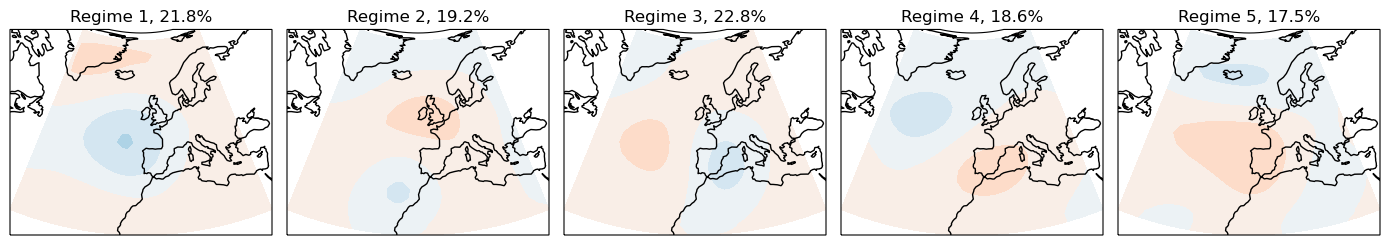

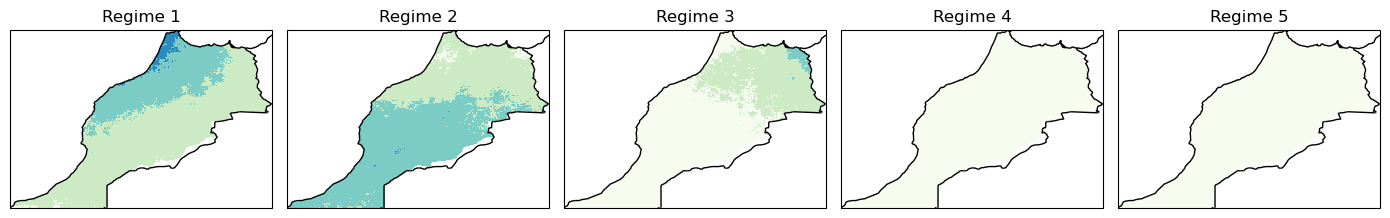

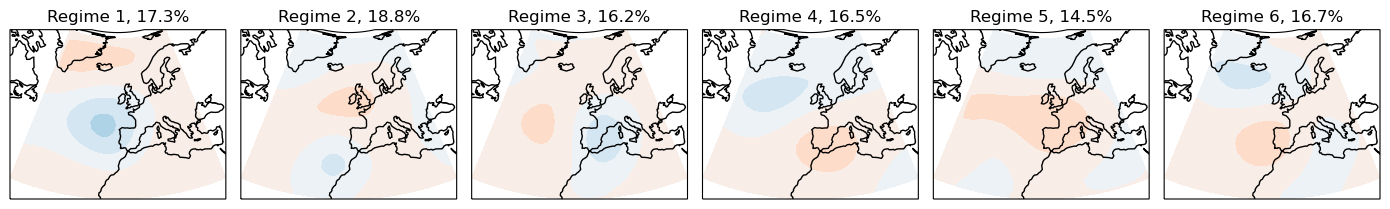

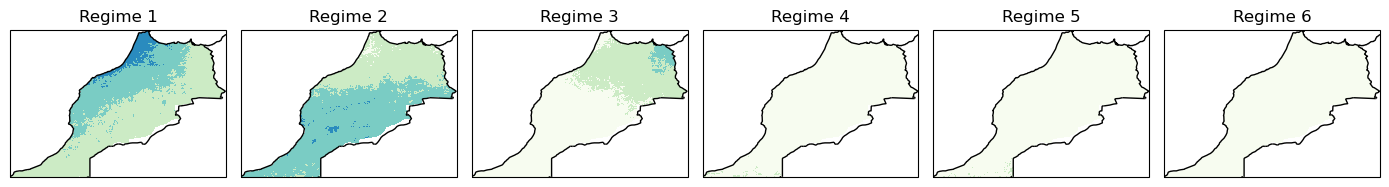

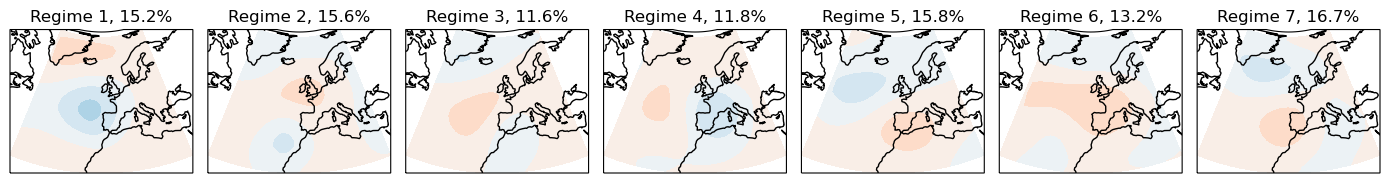

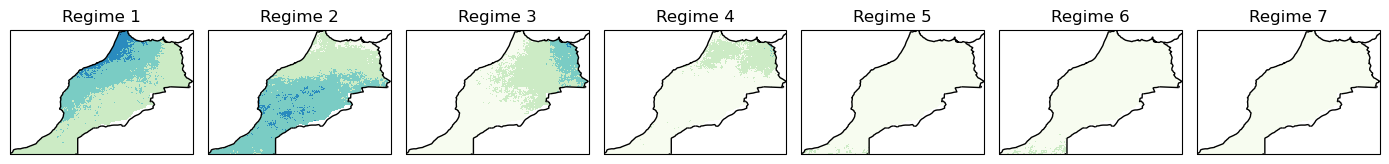

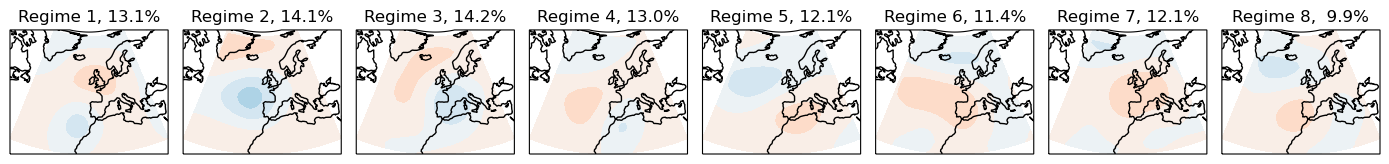

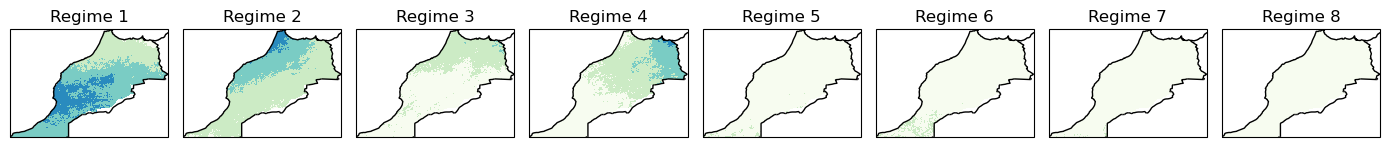

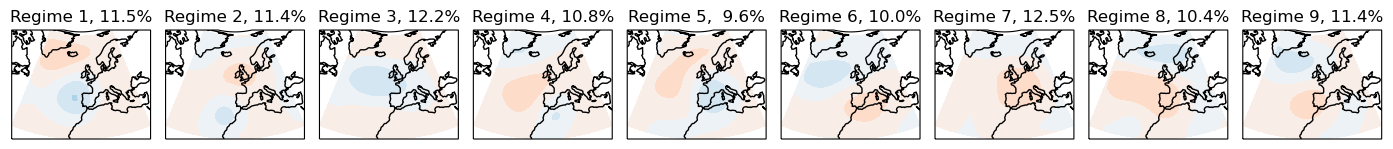

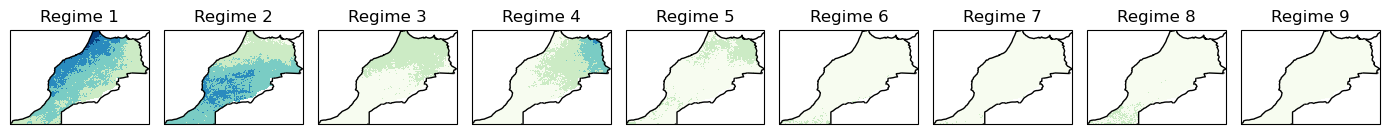

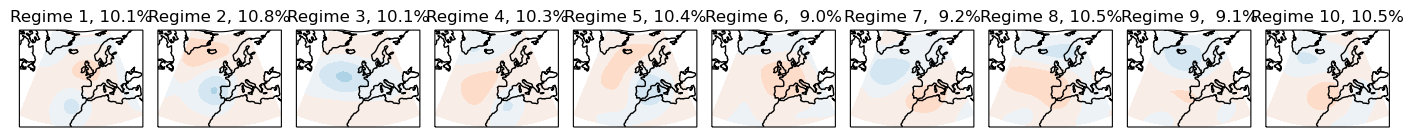

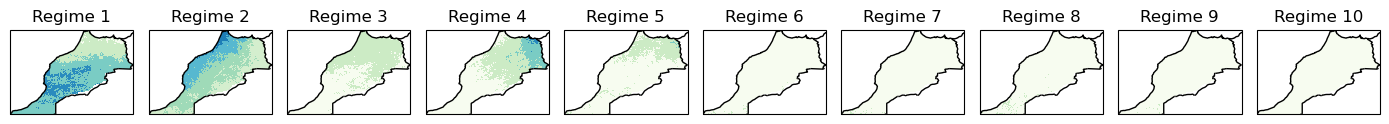

In [12]:
#for k in [4]:
for k in [5, 6, 7, 8, 9, 10]:
    
    print(k)
    
    # calculate clusters
    nt,ny,nx =z500.values.shape
    cca_clusters = KMeans(n_clusters=k, n_init=50, random_state=0).fit(z500_cca)
    
    # reorder labels
    precip_sum = pd.DataFrame(pr_spatial.values).groupby(cca_clusters.labels_).sum().reset_index()
    precip_sum['index']=precip_sum['index'].astype('int')
    precip_sum = precip_sum.rename(columns={"index": "index_old"})
    precip_sum = precip_sum.sort_values(by=0, ascending=False)
    precip_sum['index_new'] = np.arange(precip_sum.shape[0])

    labels_reordered = cca_clusters.labels_.copy()
    for i in range(len(cca_clusters.labels_)):
        new_label = precip_sum[precip_sum['index_old']==cca_clusters.labels_[i].astype('int')]['index_new'].values[0]
        labels_reordered[i] = new_label
        
    # save labels
    d = {'k': k, 'label': cca_clusters.labels_}
    df = pd.DataFrame(data=d)
    df.to_csv(filepath_cca_kmeans+'cluster_labels_'+str(k)+'.csv')
        
    d = {'k': k, 'label': labels_reordered}
    df = pd.DataFrame(data=d)
    df.to_csv(filepath_cca_kmeans+'cluster_labels_'+str(k)+'_preciporder.csv')
    
    # calculate and save cluster centers
    z500_newcoords = z500_2.assign_coords(label=("time", labels_reordered))
    centroids_xr_preciporder = z500_newcoords.groupby('label').mean(dim='time')
    centroids_flat_preciporder = cf.reshape_data_for_clustering(centroids_xr_preciporder)
    
    df = pd.DataFrame(data=centroids_flat_preciporder)
    df.to_csv(filepath_cca_kmeans+'cluster_centers_'+str(k)+'_preciporder.csv')

    # skill scores
    
    bss_95 = sc.calculate_95pc_skill_score(cluster_number_z500 = k, 
                                                  z500_cluster_labels = cca_clusters.labels_, 
                                                  pr_spatial = pr_spatial)
    print(bss_95)

    bss_cluster = sc.calculate_cluster_skill_score(cluster_number_pr = 5, 
                                                      cluster_number_z500 = k, 
                                                             pr_cluster_labels = np.array(pr_labels['labels']),
                                                             z500_cluster_labels = cca_clusters.labels_)
    print(bss_cluster)
    bss_tercile = sc.calculate_tercile_skill_score(cluster_number_z500 = k, 
                                                  z500_cluster_labels = cca_clusters.labels_, 
                                                  pr_spatial = pr_spatial)
    
    ## first round
    #df = pd.DataFrame(data={'k': [k], 'bss_cluster': [bss_cluster], 'bss_95': [bss_95], 'bss_tercile': [bss_tercile]})
    #df.to_csv(filepath_cca_kmeans+'skill_score.csv', index=False)
    
    ## after
    df_prior = pd.read_csv(filepath_cca_kmeans+'skill_score.csv')
    df = pd.DataFrame(data={'k': [k], 'bss_cluster': [bss_cluster], 'bss_95': [bss_95], 'bss_tercile': [bss_tercile]})
    df_new = df_prior.append(df)
    df_new.to_csv(filepath_cca_kmeans+'skill_score.csv', index=False)
    
    
    # persistence
    
    persistence = cf.calculate_regime_length(cca_clusters.labels_).groupby('Regime').mean()['Length'].reset_index()
    
    ## first round
    #df = pd.DataFrame(data={'k': [str(k)]*k,
    #                    'Method': ['CCA']*k,
    #                    'Regime': persistence['Regime'].values, 
    #                    'Persistence': persistence['Length'].values})#

    #df.to_csv(filepath_cca_kmeans+'persistence.csv', index=False)
    
    ## after
    df_prior = pd.read_csv(filepath_cca_kmeans+'persistence.csv')
    df = pd.DataFrame(data={'k': [str(k)]*k, 
                        'Method': ['CCA']*k,
                        'Regime': persistence['Regime'].values, 
                        'Persistence': persistence['Length'].values})
    df_new = df_prior.append(df)
    df_new.to_csv(filepath_cca_kmeans+'persistence.csv', index=False)
    
    
    # silhouette
    
    sil_score = silhouette_score(cf.reshape_data_for_clustering(z500), cca_clusters.labels_)
    print(sil_score)
    
    ## first round
    #df = pd.DataFrame(data={'k': [k], 'silhouette_score': [sil_score], 'method': ['CCA']})
    #df.to_csv(filepath_cca_kmeans+'silhouette_score.csv', index=False)
    
    ## after
    df_prior = pd.read_csv(filepath_cca_kmeans+'silhouette_score.csv')
    df = pd.DataFrame(data={'k': [k], 'silhouette_score': [sil_score], 'method': ['CCA']})
    df_new = df_prior.append(df)
    df_new.to_csv(filepath_cca_kmeans+'silhouette_score.csv', index=False)
        
        
    # plot cluster centers
    
    clusters_cca_vis = cf.visualise_contourplot_8(dataset_xarray = centroids_xr_preciporder, 
                                                          unit = '[m]', 
                                                          cluster_results = cca_clusters, 
                                                          regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5', 'Regime 6',
                                                                         'Regime 7', 'Regime 8', 'Regime 9', 'Regime 10'],
                                                  vmin=-4, vmax=4.5, steps=0.5, col_number = k,
                                                  color_scheme = 'RdBu_r', borders=False, 
                                                  projection = ccrs.AlbersEqualArea(central_longitude=-10, central_latitude=50)
                                          )
    plt.savefig(filepath_cca_kmeans+'cluster_centers_'+str(k)+'.png')
    
    # plot precipitation odds ratio
    
    pr_qn95_ratio = cf.calculate_conditional_probability_change_label(threshold_matrix = threshold_qn95, 
                                                        labels=labels_reordered,
                                                       comparison = 'ratio', shift_value=0)

    pr_qn95_vis = cf.visualise_spatial_oddsratio_8(dataset_xarray = pr_qn95_ratio, unit='', 
                                   color_scheme = 'GnBu', vmin = 0, vmax=5, steps=6, 
                                   title = 'Odds ratio of 95th percentile precipitation',
                                             regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5', 'Regime 6',
                                                                         'Regime 7', 'Regime 8', 'Regime 9', 'Regime 10'],
                                   borders=True, projection=ccrs.PlateCarree(central_longitude=0),
                                              col_number=k)

    plt.savefig(filepath_cca_kmeans+'precip_odds_ratio_'+str(k)+'.png')

### apply to S2S forecasts

In [14]:
k=5
cca_clusters = KMeans(n_clusters=k, n_init=50, random_state=0).fit(z500_cca)

In [15]:
from datetime import datetime, timedelta

reference_dates_mmdd = [
    '0101', '0108', '0115', '0122', '0201', '0208', '0215', '0222',
    '0301', '0308', '0315', '0322', 
    '0901', '0908', '0915', '0922', '1001', '1008', '1015', '1022',
    '1101', '1108', '1115', '1122', '1201', '1208', '1215', '1222',
]

conditional_probabilities_ls = []

for reference_date in reference_dates_mmdd:
    
    print(reference_date)
    
    ds_ensemble = xr.open_dataset("../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_perturbed_members_1980"+str(reference_date)+"-2020"+str(reference_date)+".grb", engine='cfgrib')
    ds_single = xr.open_dataset("../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_1980"+str(reference_date)+"-2020"+str(reference_date)+".grb", engine='cfgrib')

    ds = xr.concat([ds_ensemble, ds_single], dim='number')
    ds_days = ds.groupby(ds['step'].dt.days).mean()

    ds_days_anom = ds_days - ds_days.mean(dim=['time', 'number'])
    ds_days_anom = ds_days_anom/ds_days_anom.std(dim=['time', 'number'])
    ds_days_anom = ds_days_anom.rolling(days=5, min_periods=1, center=True).mean()
    ds_days_anom = ds_days_anom.reindex(latitude=list(reversed(ds_days_anom.latitude)))

    ds_days_anom = ds_days_anom.where(ds_days_anom['longitude'] > -50.5, drop=True)
    ds_days_anom = ds_days_anom*weights
    
    for leadtime in range(47):
        
        probabilities = np.zeros(shape=(41, k))
        
        for member in range(11):

            selected = ds_days_anom['z'][leadtime, member, :, :, :]
            
            nt,ny,nx = selected.values.shape
            selected_reshaped = np.reshape(selected.values, [nt, ny*nx], order='F')

            X_cca, Y_cca = ridge.transform([selected_reshaped, pr_reshaped_cca[0:41, :]])
            cluster_labels = cca_clusters.predict(X_cca)
            
            for i in range(len(cluster_labels)):
                probabilities[i, cluster_labels[i].astype('int')] = probabilities[i, cluster_labels[i].astype('int')]+(1/11)
            

        conditional_probabilities_ls.append(pd.DataFrame(data={'Method': 'CCA',
                                                                'forecast_init': selected['time'].dt.date,
                                                               'valid_date': selected['time'].dt.date + timedelta(days=leadtime),
                                                               'leadtime': leadtime,
                                                               str(0): probabilities[:, 0],
                                                               str(1): probabilities[:, 1],
                                                               str(2): probabilities[:, 2],
                                                               str(3): probabilities[:, 3],
                                                               str(4): probabilities[:, 4],}))
                                                                                    
conditional_probabilities = pd.concat(conditional_probabilities_ls)
conditional_probabilities.to_csv(filepath_cca_kmeans+'s2s/conditional_probabilities_'+str(k)+'.csv')

0101


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800101-20200101.grb.923a8.idx' incompatible with GRIB file


0108


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800108-20200108.grb.923a8.idx' incompatible with GRIB file


0115


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800115-20200115.grb.923a8.idx' incompatible with GRIB file


0122


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800122-20200122.grb.923a8.idx' incompatible with GRIB file


0201


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800201-20200201.grb.923a8.idx' incompatible with GRIB file


0208


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800208-20200208.grb.923a8.idx' incompatible with GRIB file


0215


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800215-20200215.grb.923a8.idx' incompatible with GRIB file


0222


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800222-20200222.grb.923a8.idx' incompatible with GRIB file


0301


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800301-20200301.grb.923a8.idx' incompatible with GRIB file


0308


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800308-20200308.grb.923a8.idx' incompatible with GRIB file


0315


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800315-20200315.grb.923a8.idx' incompatible with GRIB file


0322


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800322-20200322.grb.923a8.idx' incompatible with GRIB file


0901


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800901-20200901.grb.923a8.idx' incompatible with GRIB file


0908


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800908-20200908.grb.923a8.idx' incompatible with GRIB file


0915


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800915-20200915.grb.923a8.idx' incompatible with GRIB file


0922


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800922-20200922.grb.923a8.idx' incompatible with GRIB file


1001


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801001-20201001.grb.923a8.idx' incompatible with GRIB file


1008


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801008-20201008.grb.923a8.idx' incompatible with GRIB file


1015


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801015-20201015.grb.923a8.idx' incompatible with GRIB file


1022


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801022-20201022.grb.923a8.idx' incompatible with GRIB file


1101


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801101-20201101.grb.923a8.idx' incompatible with GRIB file


1108


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801108-20201108.grb.923a8.idx' incompatible with GRIB file


1115


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801115-20201115.grb.923a8.idx' incompatible with GRIB file


1122


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801122-20201122.grb.923a8.idx' incompatible with GRIB file


1201


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801201-20201201.grb.923a8.idx' incompatible with GRIB file


1208


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801208-20201208.grb.923a8.idx' incompatible with GRIB file


1215


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801215-20201215.grb.923a8.idx' incompatible with GRIB file


1222


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801222-20201222.grb.923a8.idx' incompatible with GRIB file
